In [9]:
import pandas as pd
import numpy as np
from shapely.geometry import box, Polygon, LinearRing
import numpy as np
from scipy.spatial import ConvexHull
from shapely.affinity import scale, translate
import itertools

import matplotlib.pyplot as plt
import geopandas as gpd

from area_derivations import iou, minimum_bounding_rectangle, get_best_fit_rect

In [10]:
v1_ref = (60, 92)

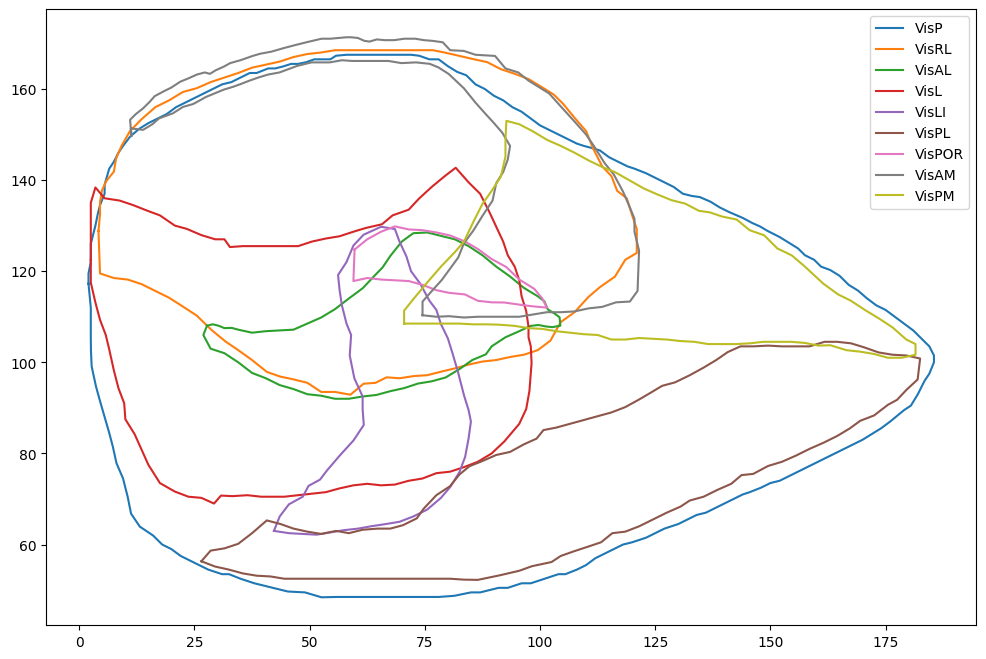

In [11]:
areas = ["VisP", "VisRL", "VisAL", "VisL", "VisLI", "VisPL", "VisPOR", "VisAM", "VisPM"]

plt.figure(figsize=(12, 8))

for area in areas:
    polygon = Polygon(pd.read_csv(f"digitized_data/{area}.csv").values)
    x, y = polygon.exterior.xy
    plt.plot(list(x), list(y), label=area)

plt.legend()

In [12]:
# area_pairs = list(itertools.product([areas[0]], areas[1:]))
# area_pairs

In [13]:
bounding_rectangles = []
visp_polygon = Polygon(pd.read_csv(f"digitized_data/VisP.csv").values)
visp_bound = Polygon(minimum_bounding_rectangle(visp_polygon))

for area in areas:
    polygon = Polygon(pd.read_csv(f"digitized_data/{area}.csv").values)
    min_bounding_rect = Polygon(minimum_bounding_rectangle(polygon))
    bounding_rectangles.append(
        visp_bound.intersection(min_bounding_rect)
    )
    

In [14]:
np.array(visp_polygon.exterior.xy).T.shape

(199, 2)

In [15]:
best_rects = {}
best_ious = {}
#AM and PM don't work for some reason? Which is kind of convienent...
areas = ["VisP", "VisRL", "VisAL", "VisL", "VisLI", "VisPL", "VisPOR"]
for area in areas:
    best_rect, best_iou = get_best_fit_rect(area)
    best_rects[area] = best_rect
    best_ious[area] = best_iou

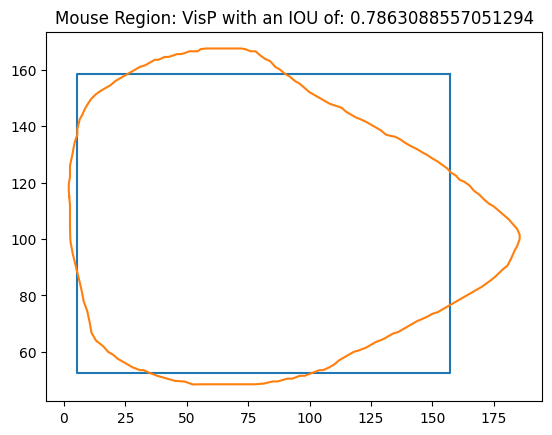

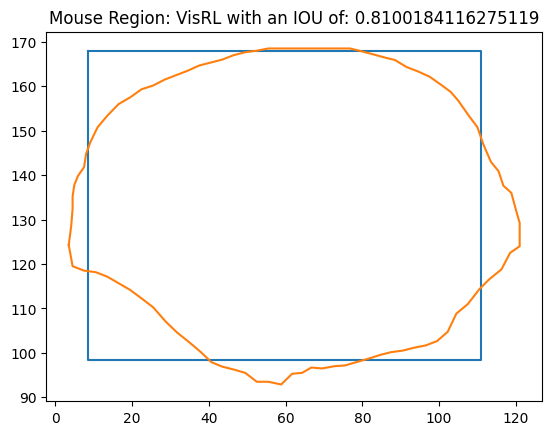

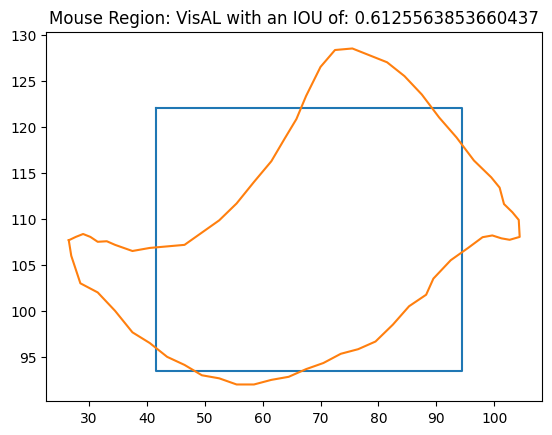

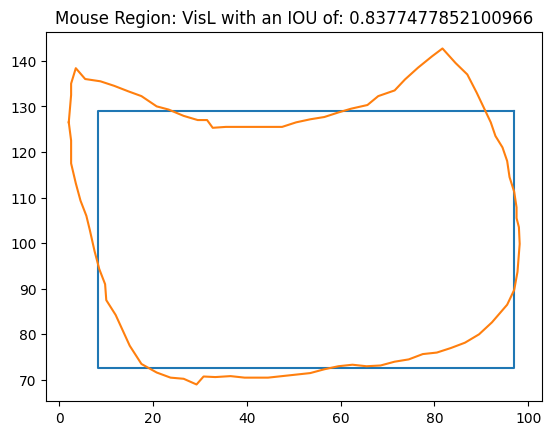

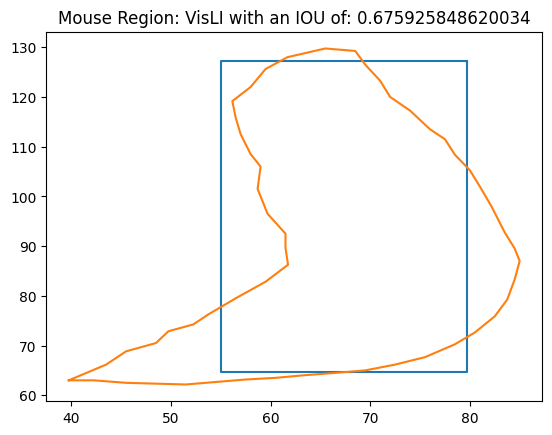

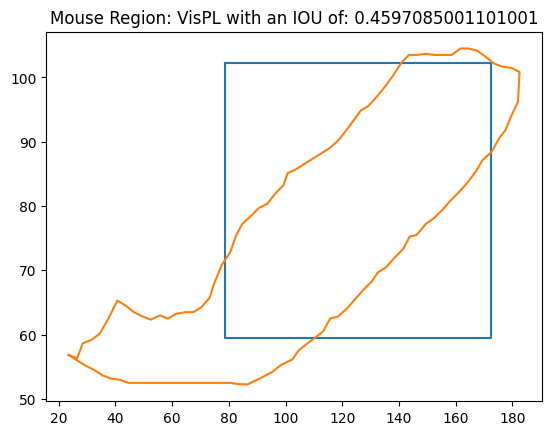

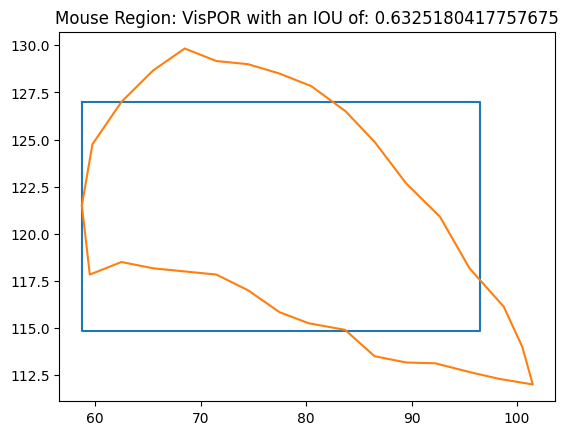

In [16]:
for area in areas:
    plt.figure()
    area_df = pd.read_csv(f"digitized_data/{area}.csv", header=None)
    area_polygon = Polygon(area_df.values)

    best_rect = best_rects[area]

    plt.plot(*best_rect.exterior.xy)
    plt.plot(*area_polygon.exterior.xy)

    plt.title(f"Mouse Region: {area} with an IOU of: {best_ious[area]}")

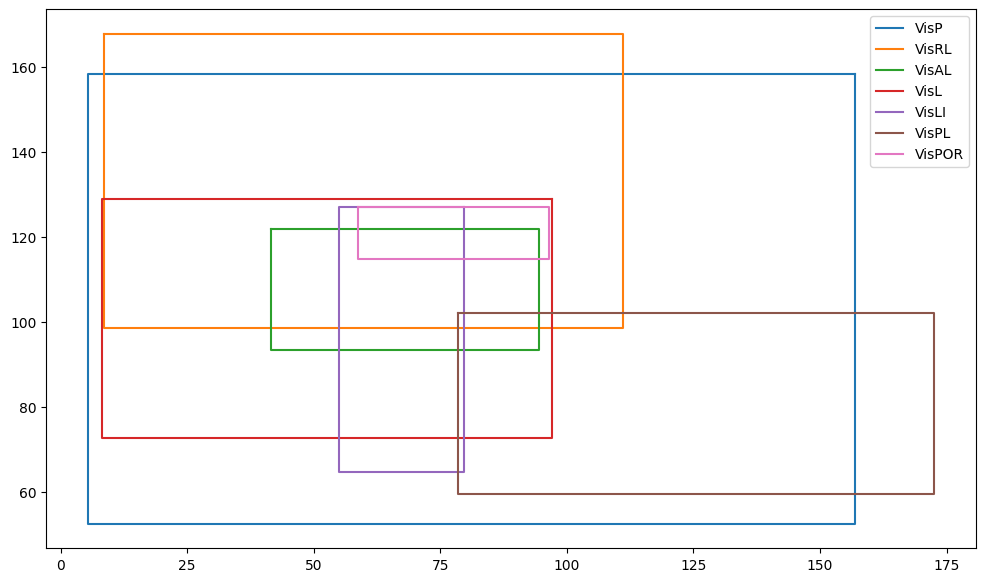

In [17]:
def plot_visareas(rectangles):
    plt.figure(figsize=(12, 7))
    for area in areas:
        # area_df = pd.read_csv(f"digitized_data/{area}.csv", header=None)
        # area_polygon = Polygon(area_df.values)
        plt.plot(*rectangles[area].exterior.xy, label=area)

    plt.legend()
plot_visareas(best_rects)

In [18]:
# Extend vis areas to cover visPOR
minx, miny, maxx, maxy = best_rects["VisPOR"].bounds
visp_minx, visp_miny, visp_maxx, visp_maxy= best_rects["VisP"].bounds
modified_rects = {}
for area in areas:
    poly_minx, poly_miny, poly_maxx, poly_maxy = best_rects[area].bounds
    poly_x1 = max(min(poly_minx, minx), visp_minx)
    poly_y1 = max(min(poly_miny, miny), visp_miny)
    poly_x2 = min(max(poly_maxx, maxx), visp_maxx)
    poly_y2 = min(max(poly_maxy, maxy), visp_maxy)
    polyg = Polygon(np.array([
            [poly_x1, poly_y1], [poly_x1, poly_y2], 
            [poly_x2, poly_y2], [poly_x2, poly_y1]])
        )
    modified_rects[area]=polyg
    

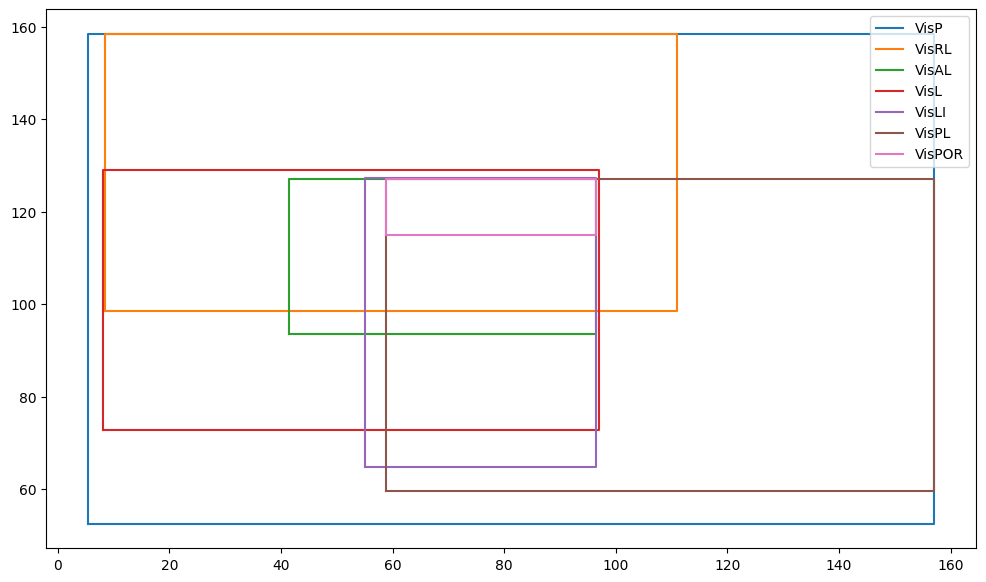

In [19]:
plot_visareas(modified_rects)


In [20]:
# update a rectangle boundary based on factors
def modify_rectangle(rectangle, factors):
    poly_x1, poly_y1, poly_x2, poly_y2 = rectangle.bounds
    poly_x1 += factors[0]
    poly_y1 += factors[1]
    poly_x2 += factors[2]
    poly_y2 += factors[3] 
    
    return Polygon(np.array([
            [poly_x1, poly_y1], [poly_x1, poly_y2], 
            [poly_x2, poly_y2], [poly_x2, poly_y1]])
        )
# upadte all polygon boundaries based on given factors
def strech_polygon(polygons, factors):
    streched_polygons = {"VisP": polygons["VisP"]}
    f_idx = 0
    for area in areas:
        if area == "VisP" or area =="VisPOR":
            continue
        updated_rect = modify_rectangle(polygons[area], factors[f_idx*4:(f_idx+1)*4])
        streched_polygons[area] = updated_rect
        f_idx += 1
    streched_polygons["VisPOR"] = polygons["VisPOR"]
    return streched_polygons

# loss function maximizing the overall polygon overlap with VisP and minimizing the streching of the rectangles
def streched_iou(factors):
    new_polygons = strech_polygon(modified_rects, factors)
    combined_polygon = new_polygons[areas[1]]
    loss_val = -iou(modified_rects[areas[1]], new_polygons[areas[1]])
        
    f_idx = 0
    for area in areas:
        if area == "VisP" or area =="VisPOR":
            continue
        combined_polygon = combined_polygon.union(new_polygons[area])
        loss_val -= iou(modified_rects[area],new_polygons[area])
        
    visp_poly = modified_rects["VisP"]
    # assert combined_polygon.is_valid
    loss_val -= 100*iou(combined_polygon,visp_poly )
    return loss_val




(6_w,12)-aCMA-ES (mu_w=3.7,w_1=40%) in dimension 20 (seed=611935, Sun Sep 18 12:58:27 2022)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     12 -8.514606285584080e+01 1.0e+00 3.82e+00  4e+00  4e+00 0:00.1
    2     24 -8.868255733044764e+01 1.1e+00 3.80e+00  4e+00  4e+00 0:00.1
    3     36 -8.879239019777283e+01 1.2e+00 3.68e+00  4e+00  4e+00 0:00.2
   85   1020 -1.015227772671818e+02 3.6e+00 2.15e+00  1e+00  3e+00 0:03.2
  100   1200 -1.015748594169750e+02 4.3e+00 1.88e+00  9e-01  2e+00 0:04.5
  163   1956 -1.031642400478615e+02 8.1e+00 5.59e-01  1e-01  8e-01 0:09.5
  200   2400 -1.035829051595281e+02 1.0e+01 2.21e-01  4e-02  3e-01 0:11.4
  300   3600 -1.037222128258205e+02 2.3e+01 2.52e-02  3e-03  4e-02 0:16.8
  400   4800 -1.038149945684634e+02 1.3e+02 4.87e-02  3e-03  3e-01 0:21.9
  500   6000 -1.040383019140917e+02 1.9e+02 1.27e-01  5e-03  6e-01 0:26.3
  600   7200 -1.041244604621320e+02 1.5e+02 2.26e-02  6e-04  6e-02 0:30.4
  700   8400 -1.044739

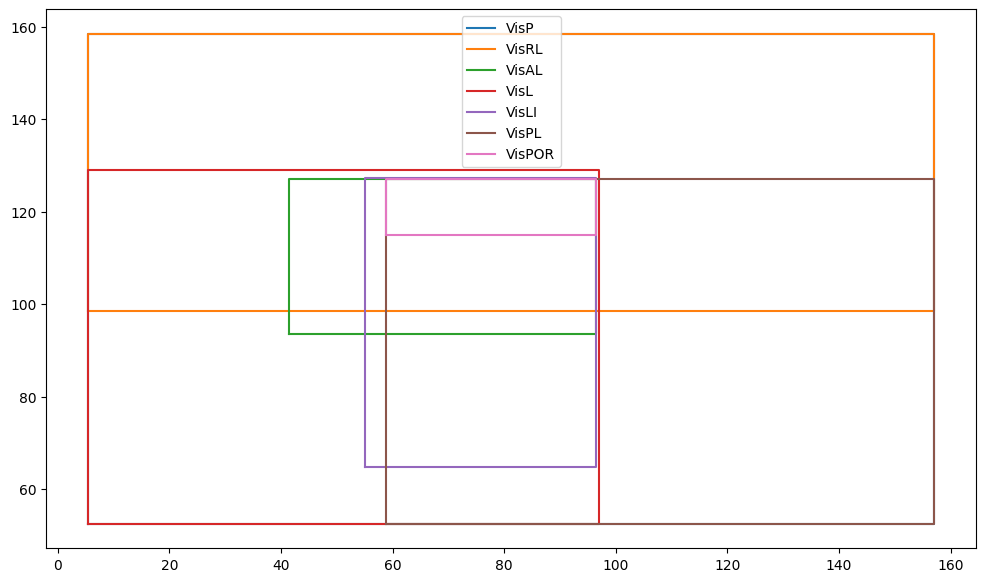

In [21]:
# use evolutionary strategy to optimize coverage of VisP while minimizing the increasing areas
import cma
res = cma.CMAEvolutionStrategy(20 * [0], 4).optimize(streched_iou).result
new_polygons=  strech_polygon(modified_rects, res[0])
plot_visareas(new_polygons)

In [22]:
visP_poly = new_polygons["VisP"]
x, y = visP_poly.exterior.xy
centroid = visP_poly.centroid

width = abs(list(x)[0] - list(x)[2])
height = abs(list(y)[0] - list(y)[1])

scaled_polys = {}
for area in areas:
    poly = new_polygons[area]
    poly = scale(poly, xfact=92/width, yfact=60/height, origin=centroid)
    scaled_polys[area] = poly

visP_poly = scaled_polys["VisP"]
x, y = visP_poly.exterior.xy
centroid = visP_poly.centroid

minX = min(list(x))
minY = min(list(y))

final_polys = {}
for area in areas:
    poly = scaled_polys[area]
    poly = translate(poly, xoff= -1*minX, yoff=-1*minY)
    final_polys[area] = poly

<Figure size 500x500 with 0 Axes>

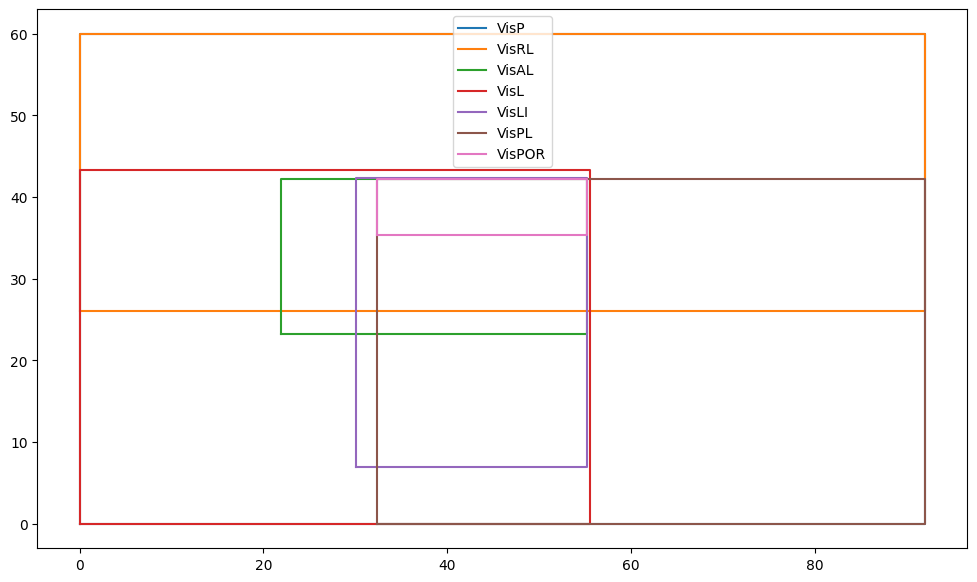

In [23]:
plt.figure(figsize=(5,5))
plot_visareas(final_polys)

In [24]:
import pickle
pickle.dump(final_polys, open( "retinomap.pkl", "wb" ) )

In [25]:
np.load('retinomap.pkl', allow_pickle=True)

{'VisP': <shapely.geometry.polygon.Polygon at 0x7f7de207c640>,
 'VisRL': <shapely.geometry.polygon.Polygon at 0x7f7de0829a60>,
 'VisAL': <shapely.geometry.polygon.Polygon at 0x7f7de0829310>,
 'VisL': <shapely.geometry.polygon.Polygon at 0x7f7de235fb20>,
 'VisLI': <shapely.geometry.polygon.Polygon at 0x7f7de235fd60>,
 'VisPL': <shapely.geometry.polygon.Polygon at 0x7f7de235fac0>,
 'VisPOR': <shapely.geometry.polygon.Polygon at 0x7f7de235faf0>}